## Terms for Use
Solvers are responsible for complying with all terms of use for the data sources they access.  All code in this document is provided using the [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).  The examples have been tested using Python 3 but have not been tested under Python 2.  Note that data providers may have changed their APIs or data formats after this notebook was published.

### Boring Details
The code cells below set up the notebook environment and load necessary libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.style.use("seaborn-dark")
import os
import json
import re
from pprint import pprint
import numpy as np
import pandas as pd
from dateutil.parser import parse # To convert strings to timestamps
import warnings
import urllib3
http = urllib3.PoolManager()
GFC_HOME = os.path.abspath("../../..")
auth_file_path = os.path.join(GFC_HOME, "src", "resources", "auth.json")
with open(os.path.join(GFC_HOME, auth_file_path), "r") as f:
    api_key_dict = json.load(f)
data_path = os.path.join(GFC_HOME, "data")

## USGS Earthquake Data
In the first GF Challenge there were some IFPs for forecasting the number of earthquakes of a certain magnitude during a certain interval.  USGS does provide a [REST API](https://earthquake.usgs.gov/fdsnws/event/1/) that will respond to queries like this and will provide output in a number of formats such as KML or GeoJSON.

### Example: Earthquake Counts Magnitude 5 or Higher
The example below constructs a query for the number of worldwide earthquakes magnitude 5 or higher between March 1 and March 31, 2019, worldwide:

In [189]:
query_url_base = "https://earthquake.usgs.gov/fdsnws/event/1/count"
return_format = "geojson"
starttime = "2019-03-01"  # YYYY-MM-DD
endtime = "2019-03-31"
min_magnitude = 5
query_url = query_url_base + "?format={}&starttime={}&endtime={}&minmagnitude={}".format(return_format, starttime, endtime, min_magnitude)
print("Our query URL is {}".format(query_url))
r = http.request("GET", query_url)
raw_data = r.data.decode()  # This produces a bytes object, we need to decode it to a string
print(raw_data)

Our query URL is https://earthquake.usgs.gov/fdsnws/event/1/count?format=geojson&starttime=2019-03-01&endtime=2019-03-31&minmagnitude=5


/Users/peterhaglich/anaconda/envs/hfc/lib/python3.5/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


{"count":125,"maxAllowed":20000}


To convert it to a dict use the `eval` statement:

In [188]:
_data = eval(raw_data)
pprint(_data)

{'count': 125, 'maxAllowed': 20000}


Now suppose we wish to restrict our query to a specific region defined by minimum and maximum values for latitude and longitude.  We do this by specifying values for `minlatitude`, `maxlatitude`, ,`minlongitude`, `maxlongitude` and adding them to the query URL.  Let's look at a large bounding box centered on Japan.

In [190]:
min_lat, max_lat = (25, 45)
min_long, max_long = (125, 155)
query_url = query_url + "&minlatitude={}&maxlatitude={}&minlongitude={}&maxlongitude={}".format(min_lat, max_lat, min_long, max_long)
print("Our query URL is {}".format(query_url))
r = http.request("GET", query_url)
raw_data = r.data.decode()  # This produces a bytes object, we need to decode it to a string
print(raw_data)

Our query URL is https://earthquake.usgs.gov/fdsnws/event/1/count?format=geojson&starttime=2019-03-01&endtime=2019-03-31&minmagnitude=5&minlatitude=25&maxlatitude=45&minlongitude=125&maxlongitude=155
{"count":11,"maxAllowed":20000}


/Users/peterhaglich/anaconda/envs/hfc/lib/python3.5/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


The above is cumbersome, so we can define a function to run the query for us:

In [193]:
def get_quake_count(starttime, endtime, min_magnitude=0, bounding_box=dict()):
    """
    Retrieves earthquake count
    :param starttime: ISO 8601 Date/Time format, assumes UTC
    :param endtime: ISO 8601 Date/Time
    :min_magnitude: Earthquakes of this magnitude or higher."&minlatitude={}&maxlatitude={}&minlongitude={}&maxlongitude={}".format(min_lat, max_lat, min_long, max_long)
    :bounding_box: dict {"min_lat", "max_lat", "min_long", "max_long"}
    :returns: integer count
    """
    query_url_base = "https://earthquake.usgs.gov/fdsnws/event/1/count"
    return_format = "geojson"
    query_url = query_url_base + "?format=geojson"
    query_url += "&starttime={}&endtime={}&minmagnitude={}".format(starttime, endtime, min_magnitude)
    if bounding_box:
        query_url += "&minlatitude={}&maxlatitude={}&minlongitude={}&maxlongitude={}".format(bounding_box[min_lat], bounding_box[max_lat],
                                                                                             bounding_box[min_long], bounding_box[max_long])
    r = http.request("GET", query_url)
    raw_data = r.data.decode()  # This produces a bytes object, we need to decode it to a string
    _data = eval(raw_data)
    return _data["count"]
 

get_quake_count("2019-03-01", "2019-03-31", 5)

/Users/peterhaglich/anaconda/envs/hfc/lib/python3.5/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


125

Just for fun, let's look at the count of earthquakes by minimum magnitude for every .1 magnitude from 0 to 10.  I'll add a statement to repress the 100 warning messages regarding making requests of HTTPS without certificate verification.

In [203]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    m_values = [m/10 for m in range(101)]
    count_dict = {m: get_quake_count(starttime="2019-03-01", endtime="2019-03-31", min_magnitude=m)
                 for m in m_values}

The chart below shows the survival plot of earthquakes by magnitude, with the count on a logarithmic scale.

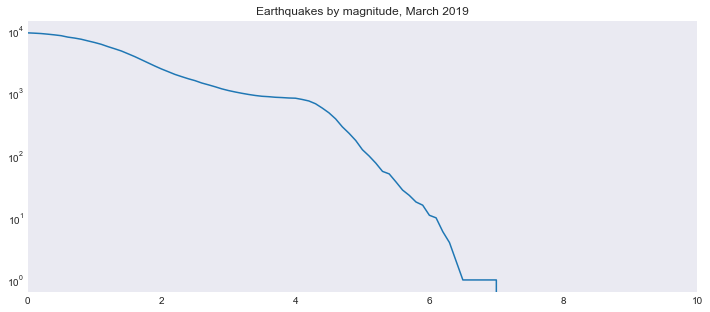

In [204]:
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,5), title="Earthquakes by magnitude, March 2019", logy=True);